In [5]:
import os, sys
import pandas as pd
import pickle
from os.path import dirname, abspath
d = os.path.abspath(os.path.join('..'))
sys.path.append(d)
from model_trial import Experiment
from util.file_processor import FileProcessor
from sklearn.metrics import mean_absolute_error
from sklearn import tree
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.5*3.125, 1.5*1.5],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*2
                           })
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import re
import graphviz
import pathlib

In [6]:
data_dir = '../../data/Data_bernoulli'
cross_validations = 3
tested_vcas = ['meet', 'teams', 'webex']

## Utility Functions

In [7]:
def load_model_trial(path):
    with open(path, 'rb') as fd:
        model_trial = pickle.load(fd)
    return model_trial

def fps_prediction_accuracy(pred, truth):
    if len(pred) != len(truth):
        raise ValueError('Length mismatch for predictions and ground truth!')
    n = len(pred)
    df = pd.DataFrame({'pred': pred.to_numpy(), 'truth': truth.to_numpy()})
    df['deviation'] = df['pred']-df['truth']
    df['deviation'] = df['deviation'].abs()
    return df['deviation'].apply(lambda x: int(x <= 2))

def parse_call_pcap_filename(file_path):
    fname = os.path.basename(file_path)
    fsp = fname[:-5].split('-')
    return int(fsp[2]), int(fsp[3]), int(fsp[4])/100, int(fsp[5])/100, int(fsp[6])

## Lookup tables

In [8]:
model_name_lookup = {
        'IP/UDP-ML': 'framesReceivedPerSecond_ml_random_LSTATS-TSTATS_rf_regressor_full_video_Data_bernoulli_cv_{}_original',
        'IP/UDP-non-ML': 'framesReceivedPerSecond_frame-lookback_random_none_none_full_video_conext_data_cv_{}_original',
        'RTP-ML': 'framesReceivedPerSecond_rtp_ml_random_LSTATS-TSTATS_rf_regressor_full_video_Data_bernoulli_cv_{}_original',
        'RTP-non-ML': 'framesReceivedPerSecond_rtp_random_none_none_full_video_conext_data_cv_{}'
}

col_map = {
        'framesReceivedPerSecond_pred': 'Frames Per Second Prediction',
        'framesReceivedPerSecond_webrtc': 'Ground Truth Frames Per Second',
        'throughput_mean_kbps': 'Throughput Mean (Kbps)',
        'throughput_std_kbps': 'Throughput Jitter (Kbps)',
        'latency_mean_ms': 'Latency Mean (ms)',
        'latency_std_ms': 'Latency Jitter (ms)',
        'MAE': 'Mean Absolute Error (# frames)'
}
feature_map = {
    'l_mean': 'Packet size mean', 'l_std': 'Packet size standard deviation', 'l_min': 'Packet size min', 'l_max': 'Packet size max', 'l_q1': 'Packet size 25th percentile', 'l_q2': 'Packet size 50th percentile', 'l_q3': 'Packet size 75th percentile', 'l_num_pkts': 'Total number of packets', 'l_num_bytes': 'Total number of bytes', 'l_num_unique': 'Total number of unique packet sizes', 'l_num_rtx': 'Number of packet retransmissions'
    't_mean': 'Packet IAT mean', 't_std': 'Packet IAT standard deviation', 't_min': 'Packet IAT min', 't_max': 'Packet IAT max', 't_q1': 'Packet IAT 25th percentile', 't_q2': 'Packet IAT 50th percentile', 't_q3': 'Packet IAT 75th percentile', 't_num_pkts': 'Total number of packets', 't_et': 'Interval end time'
}

## Feature Importance Analysis

In [9]:
class FeatureImportanceVisualizer:
    def __init__(self, model_identifier):
        self.model_identifier = model_identifier
        
    def acquire_data(self):
        merged_data = {'Feature Importance': [], 'VCA': [], 'Feature': [], 'Cross Validation': []}
        for cv in range(1, cross_validations+1):
            folder_name = model_name_lookup[self.model_identifier].format(cv)
            model_trial_path = f'{data_dir}_intermediates/{folder_name}/{folder_name}.pkl'
            model_trial = load_model_trial(model_trial_path)
            with open(f'{data_dir}_intermediates/{model_trial.trial_id}/{model_trial.trial_id}_vca_model.pkl', 'rb') as fd:
                vca_model = pickle.load(fd)
                for vca in vca_model:
                    f_imp = vca_model[vca].feature_importances
                    for feature in f_imp:
                        if f_imp[feature] == 0:
                            continue
                        merged_data['Feature Importance'].append(f_imp[feature])
                        merged_data['Feature'].append(feature)
                        merged_data['VCA'].append(vca)
                        merged_data['Cross Validation'].append(cv)
        return pd.DataFrame(merged_data)

    def visualize(self):
        df_merged = self.acquire_data()
        n_cols = len(df_merged['VCA'].unique())
        fig, ax = plt.subplots(1, n_cols, figsize=(20, 18))
        idx = 0
        for vca in df_merged['VCA'].unique():
            if n_cols <= 1:
                axis = ax
            else:
                axis = ax[idx]
            axis.set_title(f'VCA = {vca}')
            axis.set_xlim([0, 1])
            axis.grid(visible=1)
            g = sns.barplot(data=df_merged[df_merged['VCA'] == vca], y = 'Feature', x = 'Feature Importance', hue = 'Cross Validation', ax=axis, errorbar=None, orient='h')
            for i in g.containers:
                g.bar_label(i,fmt='%.2f')
            idx += 1
        plt.suptitle(f'Model = {self.model_identifier}')
        plt.show()

KeyError: 't_et'

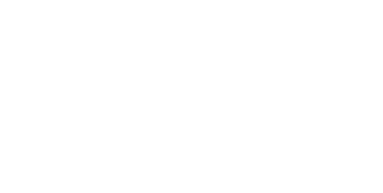

In [10]:
for vca in tested_vcas:
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    df = FeatureImportanceVisualizer('IP/UDP-ML').acquire_data()
    dfg = df[df['VCA'] == vca][['Feature', 'Feature Importance']].groupby(['Feature'])['Feature Importance'].mean().reset_index()
    dfg['Feature Importance'] = dfg['Feature Importance'].apply(lambda x: str(round(x, 2))+'%')
    dfg['Feature'] = dfg['Feature'].apply(lambda x: feature_map[x])
    t = ax.table(cellText=dfg.values,colLabels=dfg.columns,loc='center', cellLoc='center')
    t.auto_set_font_size(False)
    t.set_fontsize(8)
    t.auto_set_column_width(col=list(range(len(dfg.columns))))
    fig.savefig(f'plots/Data_bernoulli/feature_importance_{vca}.pdf')

## Analysis over network conditions

In [17]:
class NetworkConditionVisualizer:
    
    def __init__(self, model_identifiers):
        self.model_identifiers = model_identifiers
        
    def acquire_data(self):
        data = []
        for cv in range(1, cross_validations+1):
            for model_identifier in self.model_identifiers:
                folder_name = model_name_lookup[model_identifier].format(cv)
                model_trial_path = f'{data_dir}_intermediates/{folder_name}/{folder_name}.pkl'
                model_trial = load_model_trial(model_trial_path)
                with open(f'{data_dir}_intermediates/{model_trial.trial_id}/{model_trial.trial_id}_predictions.pkl', 'rb') as fd:
                    preds = pickle.load(fd)
                for vca in tested_vcas:
                    pred_merged = pd.concat(preds[vca], axis=0)
                    pred_merged = pred_merged.rename(columns = {f'{model_trial.metric}_{model_trial.estimation_method}': 'framesReceivedPerSecond_pred'})
                    pred_merged['Deviation'] = pred_merged['framesReceivedPerSecond_pred'] - pred_merged[f'{model_trial.metric}_webrtc']
                    pred_merged['MAE'] = pred_merged['Deviation'].apply(abs)
                    pred_merged['Accuracy'] = 100*fps_prediction_accuracy(pred_merged['framesReceivedPerSecond_pred'], pred_merged[f'{model_trial.metric}_webrtc'])
                    pred_merged['VCA'] = vca
                    pred_merged['Cross Validation'] = cv
                    pred_merged['Method'] = model_identifier
                    pred_merged['throughput_mean_kbps'], pred_merged['throughput_std_kbps'], pred_merged['latency_mean_ms'], pred_merged['latency_std_ms'], pred_merged['loss'] = zip(*pred_merged['file'].map(parse_call_pcap_filename))
                    data.append(pred_merged)
        return pd.concat(data, axis=0)
    
    def visualize(self, x, y, bins, y_bounds=None):
        df = self.acquire_data()
        # bins += [df[x].max()]
        fig, ax_ = plt.subplots(1, len(self.model_identifiers), figsize=(20, 4))
        ax = [ax_]
        labels = [f'{round(bins[i])}-{round(bins[i+1])}' for i in range(len(bins)-1)]
        df[col_map[x]] = pd.cut(x = df[x], bins = bins, labels = labels, include_lowest = True)
        for i, method in enumerate(self.model_identifiers):
            sns.boxplot(x=col_map[x], y = y, hue='VCA', data=df[df['Method'] == method], ax = ax[i], whis=[10,90], showfliers=False)
            ax[i].set_title(method)
            ax[i].set_xlabel(col_map[x])
            ax[i].set_ylabel(col_map[y])
            if y_bounds:
                ax[i].set_ylim(y_bounds)
            ax[i].grid(visible=1)
        plt.show()

### Ground truth FPS vs MAE

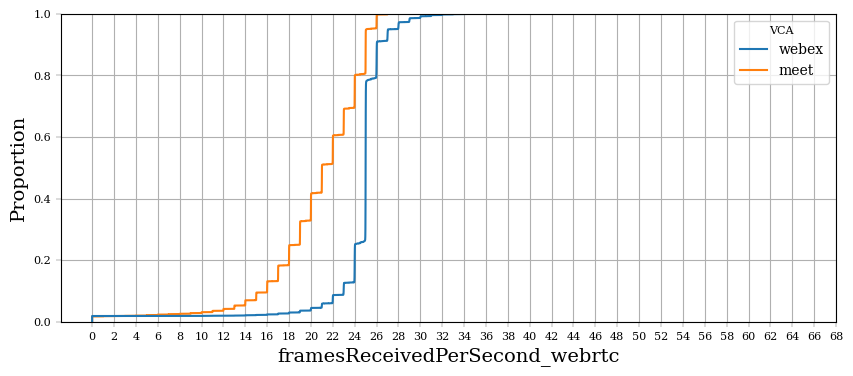

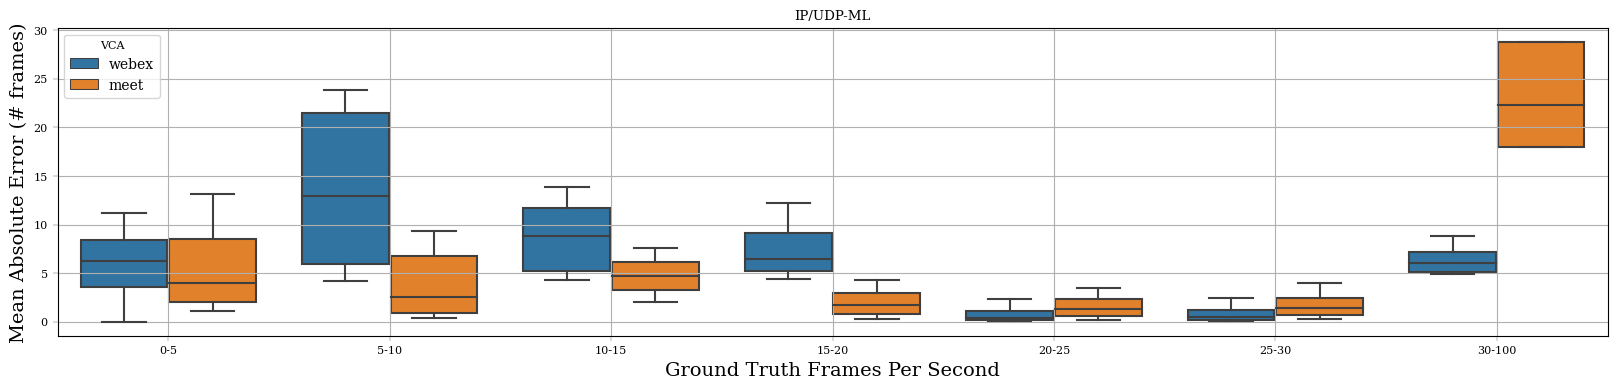

<AxesSubplot: xlabel='framesReceivedPerSecond_webrtc', ylabel='framesReceivedPerSecond_pred'>

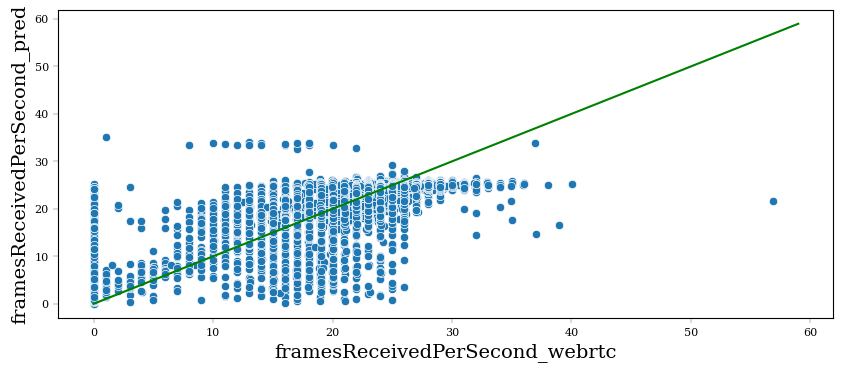

In [18]:
net_viz = NetworkConditionVisualizer(['IP/UDP-ML'])
df = net_viz.acquire_data()
plt.figure(figsize = (10, 4))
sns.ecdfplot(x='framesReceivedPerSecond_webrtc', data=df, hue='VCA')
plt.xticks(np.arange(0, 70, 2))
plt.grid()
net_viz.visualize('framesReceivedPerSecond_webrtc', 'MAE', bins=[0, 5, 10, 15, 20, 25, 30, 100])
f, a = plt.subplots(1, 1, figsize=(10, 4))
sns.scatterplot(x='framesReceivedPerSecond_webrtc', y='framesReceivedPerSecond_pred', data=df, ax=a)
sns.lineplot(x=list(range(60)), y=list(range(60)), c='g', ax=a)

In [40]:
# df = df[(df['VCA'] == 'meet') & (df['Method'] == 'IP/UDP-ML')]
# q90 = df['MAE'].quantile(0.9)
# q10 = df['MAE'].quantile(0.1)
# df = df[(df['MAE'] >= q10) & (df['MAE']) <= q90]
# df = df[df['MAE'] > 2]
# df['jitter_prod'] = df['throughput_std_kbps']*df['latency_std_ms']
# sns.scatterplot(x='throughput_mean_kbps', y='latency_mean_ms', hue='jitter_prod', palette='RdBu', data=df)
# norm = plt.Normalize(df['latency_std_ms'].min(), df['latency_std_ms'].max())
# sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
# sm.set_array([])
# plt.yticks(np.arange(0, 9000, 300))
# # Remove the legend and add a colorbar
# ax.get_legend().remove()
# plt.grid()
# plt.colorbar(sm, ax=ax, label='jitter_prod')

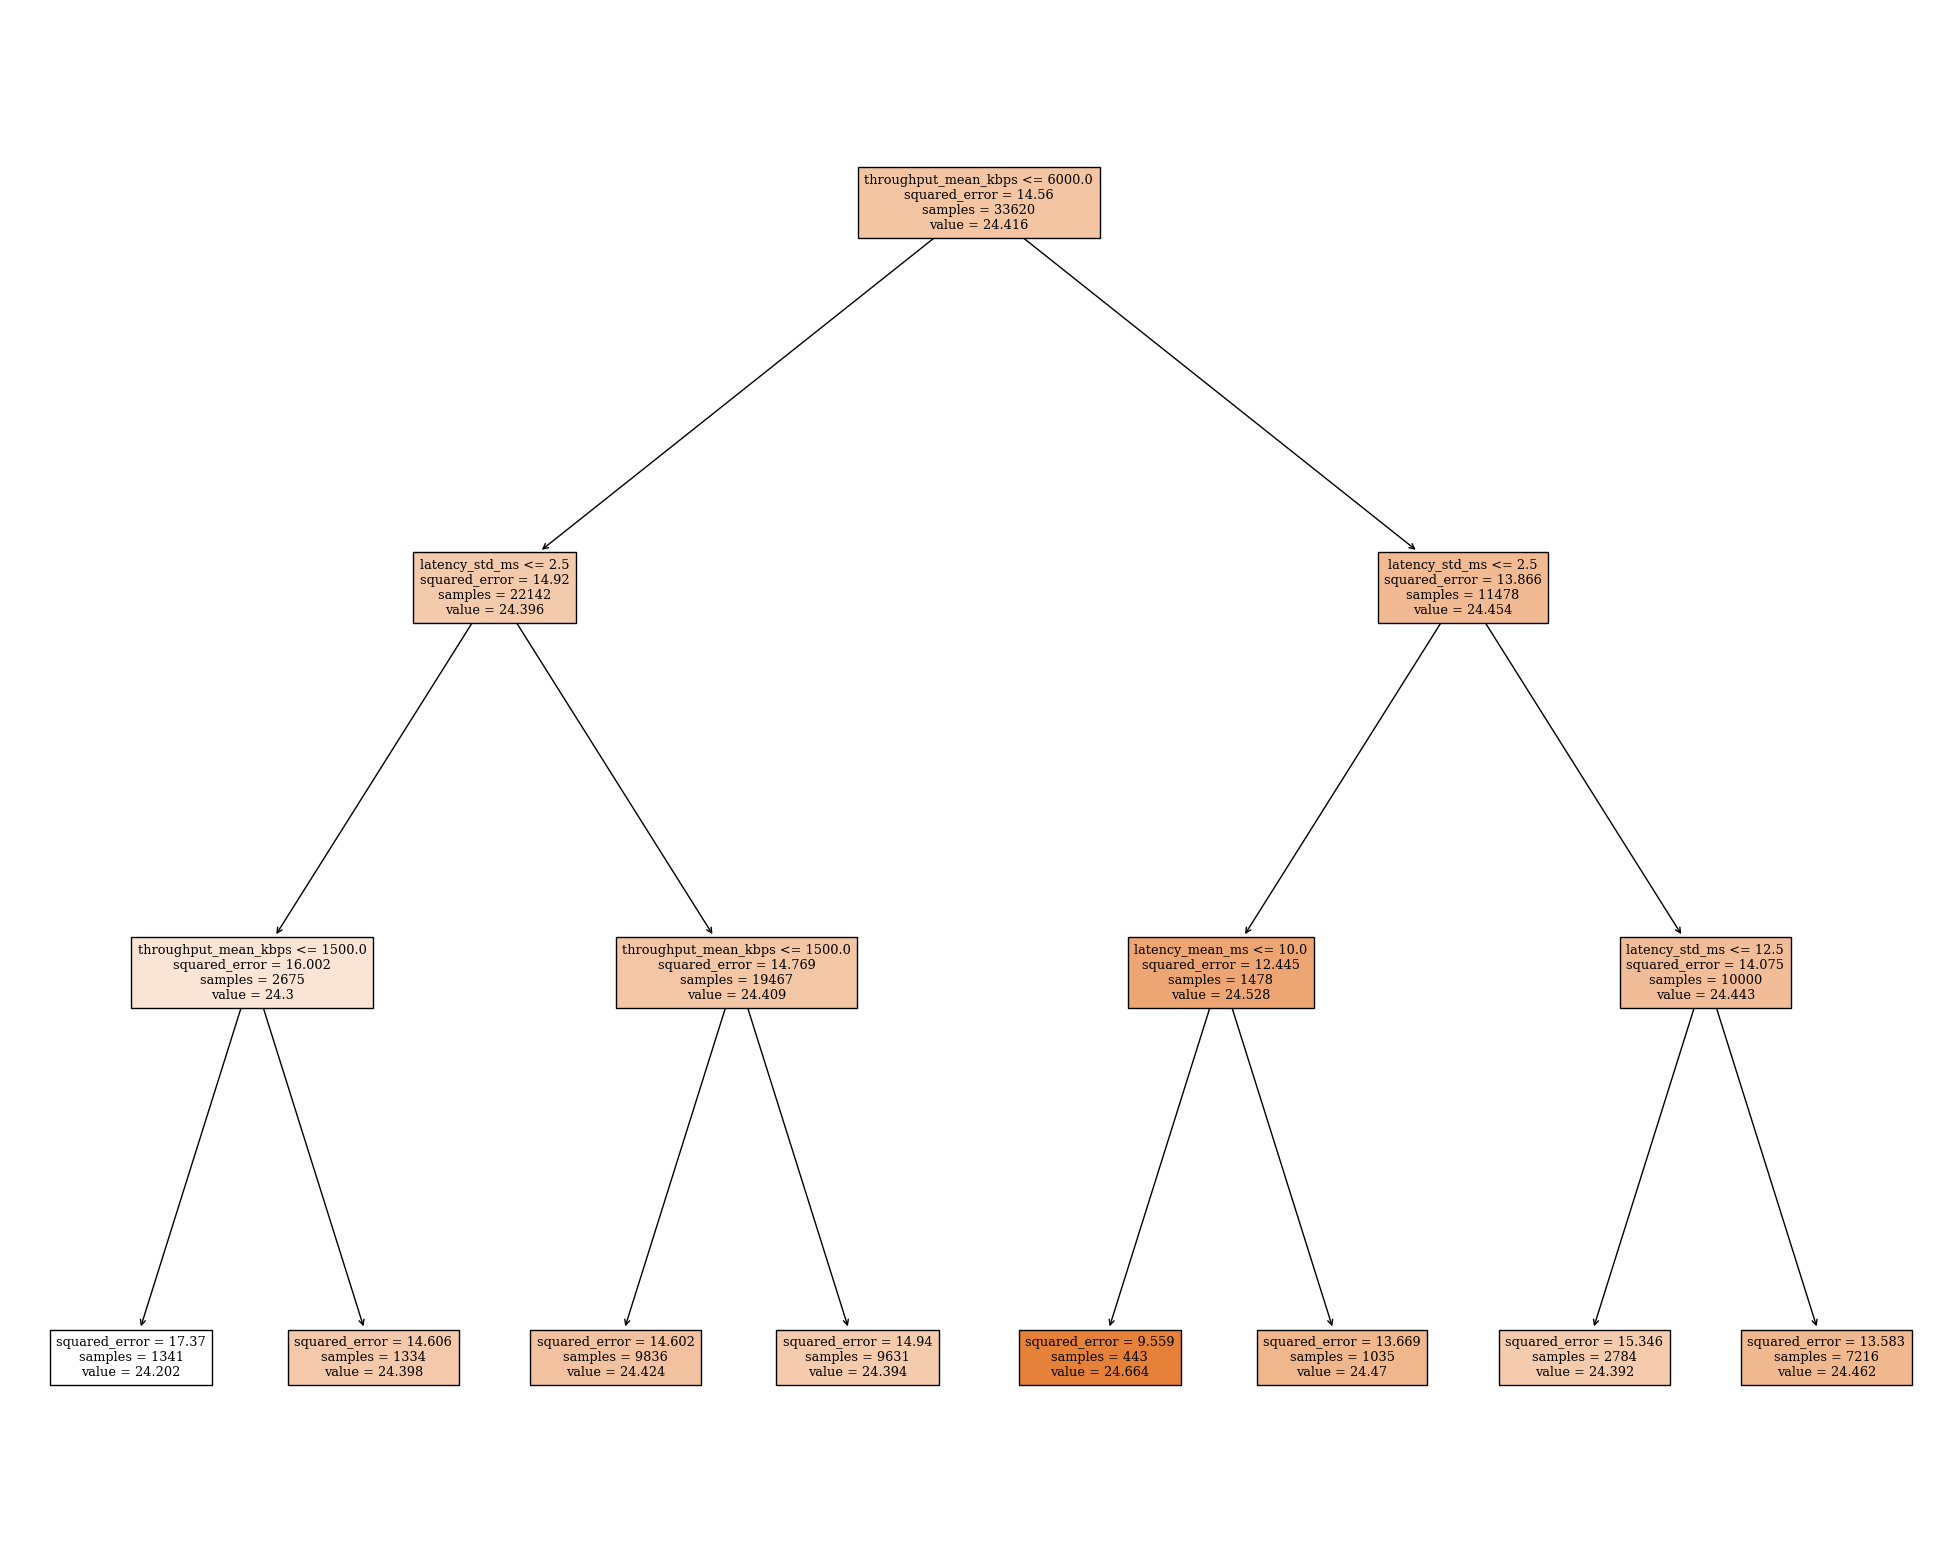

In [41]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
df = df[df['VCA'] == 'webex']
X = df[['throughput_mean_kbps', 'throughput_std_kbps', 'latency_mean_ms',
       'latency_std_ms']]
y = df['framesReceivedPerSecond_webrtc']
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X, y)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=X.columns,
                   filled=True)

### Distribution of predicted FPS

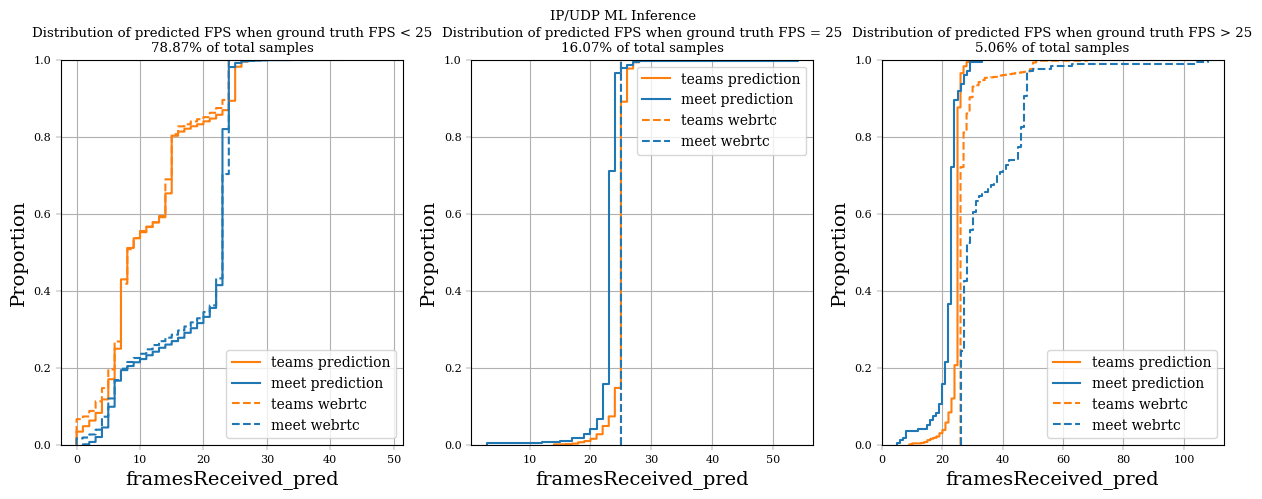

In [45]:
df = NetworkConditionVisualizer(['IP/UDP-ML']).acquire_data()
n = len(df)
# sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df)
# plt.grid()
# plt.show()

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
m = round(100*len(df[df['framesReceivedPerSecond_webrtc'] < 25])/n, 2)
sns.ecdfplot(x = 'framesReceivedPerSecond_pred', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] < 25], ax=ax[0])
ax[0].set_title(f'Distribution of predicted FPS when ground truth FPS < 25\n{m}% of total samples')
ax[0].grid()
sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] < 25], ax=ax[0])
for line in ax[0].lines[-2:]:
    line.set_linestyle("--")
ax[0].legend(labels = ['teams prediction', 'meet prediction', 'teams webrtc', 'meet webrtc'])

m = round(100*len(df[df['framesReceivedPerSecond_webrtc'] == 25])/n, 2)
sns.ecdfplot(x = 'framesReceivedPerSecond_pred', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] == 25], ax=ax[1])
ax[1].set_title(f'Distribution of predicted FPS when ground truth FPS = 25\n{m}% of total samples')
ax[1].grid()
sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] == 25], ax=ax[1])
for line in ax[1].lines[-2:]:
    line.set_linestyle("--")
ax[1].legend(labels = ['teams prediction', 'meet prediction', 'teams webrtc', 'meet webrtc'])

m = round(100*len(df[df['framesReceivedPerSecond_webrtc'] > 25])/n, 2)
sns.ecdfplot(x = 'framesReceivedPerSecond_pred', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] > 25], ax=ax[2])
ax[2].set_title(f'Distribution of predicted FPS when ground truth FPS > 25\n{m}% of total samples')
ax[2].grid()
sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] > 25], ax=ax[2])
for line in ax[2].lines[-2:]:
    line.set_linestyle("--")
ax[2].legend(labels = ['teams prediction', 'meet prediction', 'teams webrtc', 'meet webrtc'])

plt.suptitle('IP/UDP ML Inference')
plt.show()

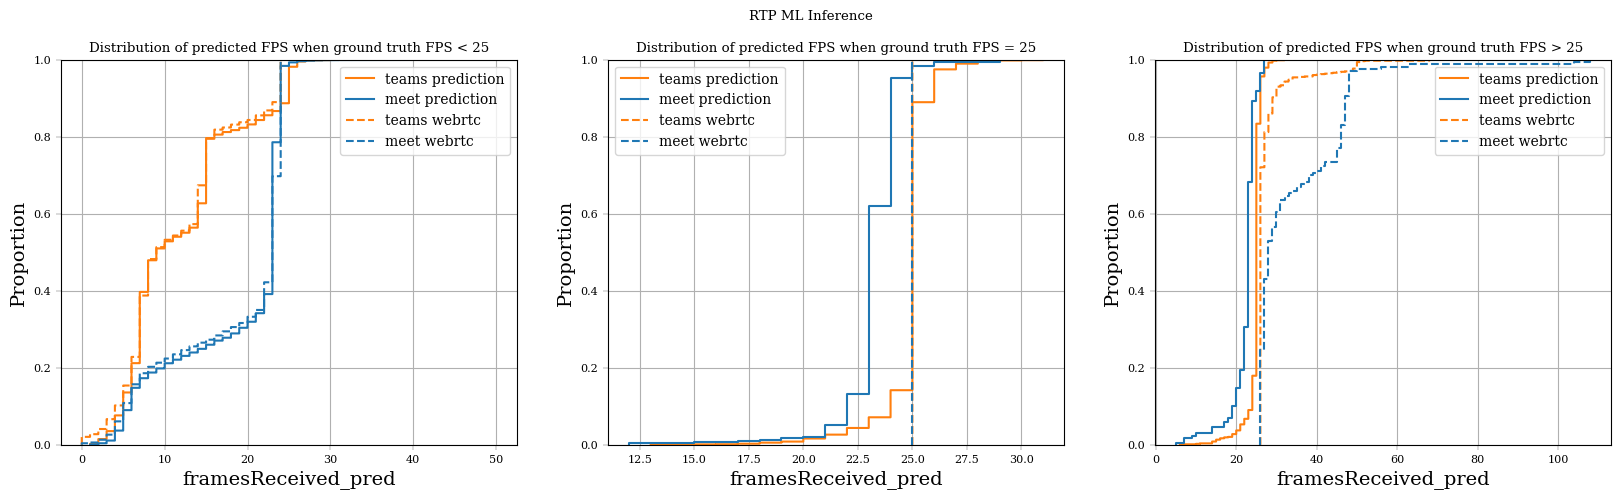

In [32]:
df = NetworkConditionVisualizer(['RTP-ML']).acquire_data()
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
sns.ecdfplot(x = 'framesReceivedPerSecond_pred', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] < 25], ax=ax[0])
ax[0].set_title(f'Distribution of predicted FPS when ground truth FPS < 25')
ax[0].grid()
sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] < 25], ax=ax[0])
for line in ax[0].lines[-2:]:
    line.set_linestyle("--")
ax[0].legend(labels = ['teams prediction', 'meet prediction', 'teams webrtc', 'meet webrtc'])

sns.ecdfplot(x = 'framesReceivedPerSecond_pred', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] == 25], ax=ax[1])
ax[1].set_title(f'Distribution of predicted FPS when ground truth FPS = 25')
ax[1].grid()
sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] == 25], ax=ax[1])
for line in ax[1].lines[-2:]:
    line.set_linestyle("--")
ax[1].legend(labels = ['teams prediction', 'meet prediction', 'teams webrtc', 'meet webrtc'])

sns.ecdfplot(x = 'framesReceivedPerSecond_pred', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] > 25], ax=ax[2])
ax[2].set_title(f'Distribution of predicted FPS when ground truth FPS > 25')
ax[2].grid()
sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] > 25], ax=ax[2])
for line in ax[2].lines[-2:]:
    line.set_linestyle("--")
ax[2].legend(labels = ['teams prediction', 'meet prediction', 'teams webrtc', 'meet webrtc'])

plt.suptitle('RTP ML Inference')
plt.show()

### Mean Throughput vs MAE

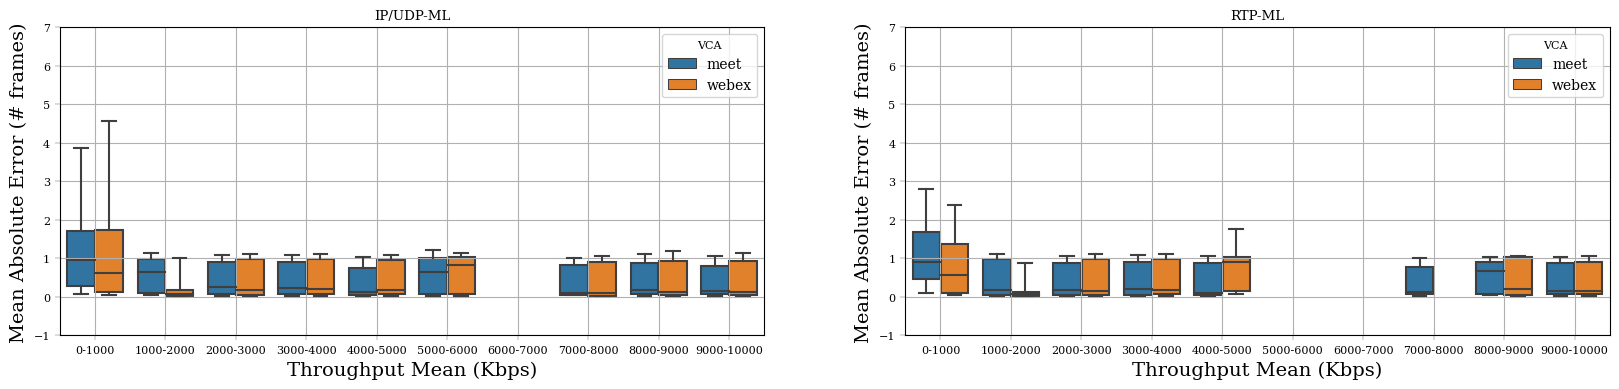

In [30]:
NetworkConditionVisualizer(['IP/UDP-ML', 'RTP-ML']).visualize('throughput_mean_kbps', 'MAE', y_bounds=[-1, 7], bins=list(range(0, 10001, 1000)))

### Throughput Jitter vs MAE

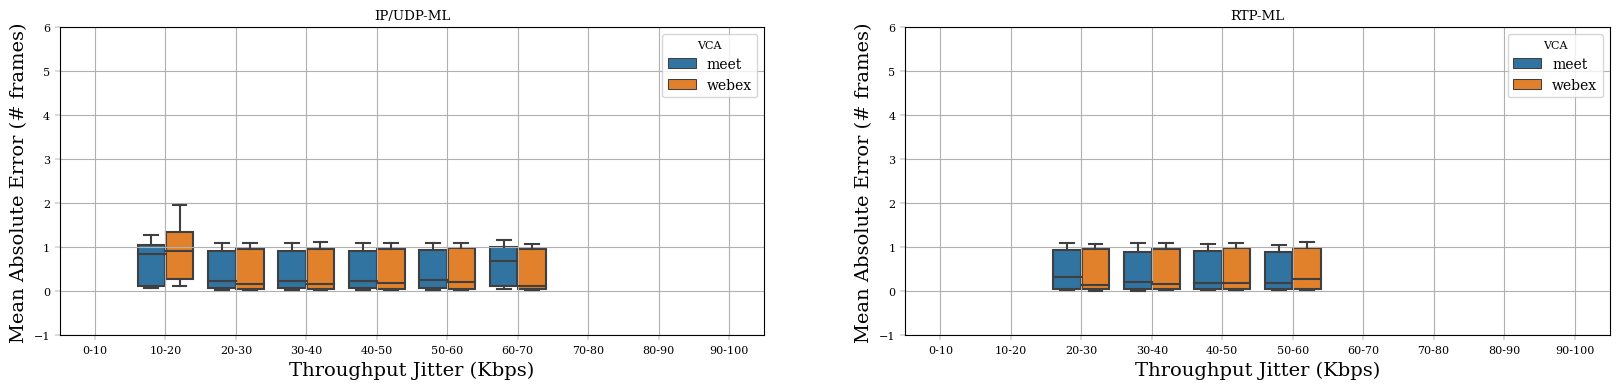

In [33]:
NetworkConditionVisualizer(['IP/UDP-ML', 'RTP-ML']).visualize('throughput_std_kbps', 'MAE', y_bounds=[-1, 6], bins=list(range(0, 101, 10)))

### Mean Latency vs MAE

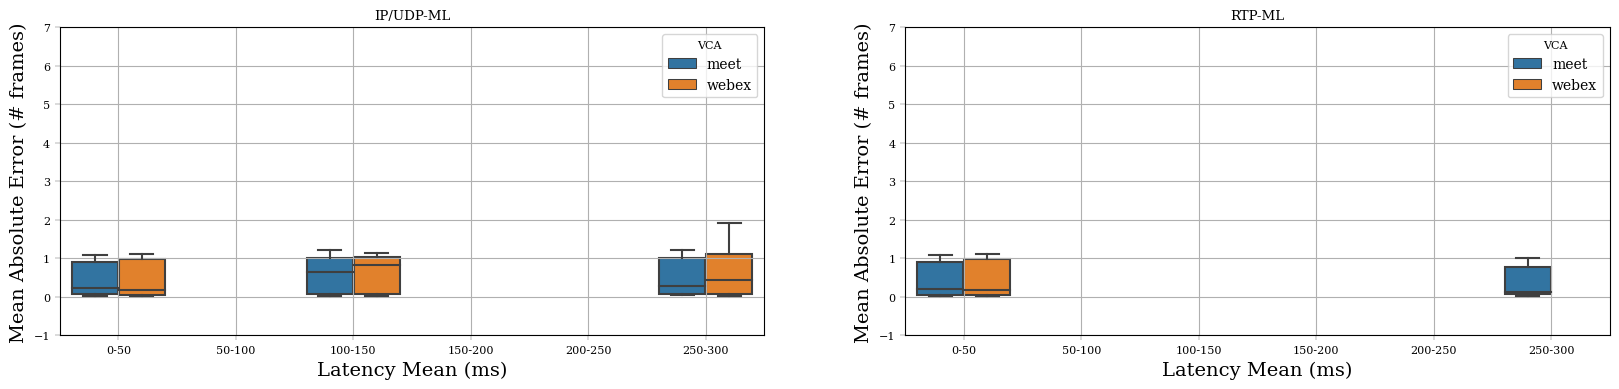

In [36]:
NetworkConditionVisualizer(['IP/UDP-ML', 'RTP-ML']).visualize('latency_mean_ms', 'MAE', y_bounds=[-1, 7], bins=list(range(0, 350, 50)))

### Latency jitter vs MAE

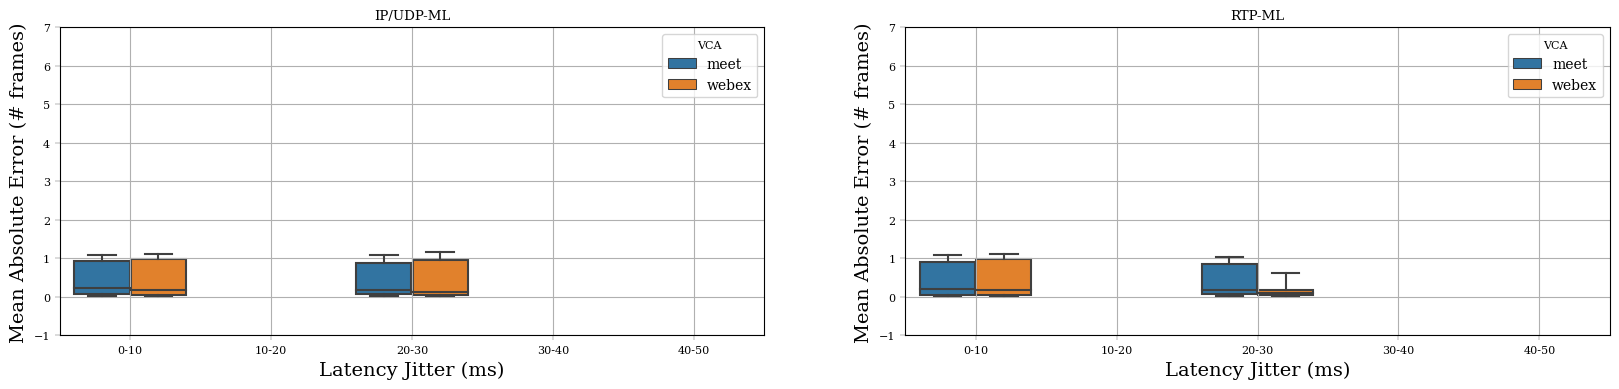

In [39]:
NetworkConditionVisualizer(['IP/UDP-ML', 'RTP-ML']).visualize('latency_std_ms', 'MAE', y_bounds=[-1, 7], bins=list(range(0, 51, 10)))